# Projeto Final de Mineração - SEFAZ


## 1) Preparação do ambiente e importação das bibliotecas necessárias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(1, '/content/drive/My Drive/TrabalhoFinal')

In [3]:

import cleaner

import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics

import seaborn as sn
import math
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2) Importação e análise inicial do dataset

In [4]:
df = pd.read_csv('/content/drive/My Drive/TrabalhoFinal/ArquivosPrimeiraPaginaAjustados.csv')
df

,Title,Content,Label
0,"Ato Declaratorio nº 01, de 2013",\n* Publicado no DOE em 01/02/2013\nATO DECLA...,atos declaratorios
1,"Ato Declaratorio nº 02, de 2013",\n* Publicado no DOE em 01/02/2013\nATO DECLA...,atos declaratorios
2,"Ato Declaratório nº 01, de 1998",ATO DECLARATÓRIO Nº 01/1998\n07/01/1998\n* Pub...,atos declaratorios
3,"Ato Declaratório nº 01, de 1999",ATO DECLARATÓRIO Nº 01/1999\n14/01/1999\n* Pub...,atos declaratorios
4,"Ato Declaratório nº 01, de 2000",ATO DECLARATÓRIO Nº 01/2000\n29/03/2000\n* Pub...,atos declaratorios
...,...,...,...
3601,"Resolução SEFAZ_SETUR nº 02, de 2019",GOVERNO DO \nESTADO DO CEARÁ\nSecretaria da Fa...,resolucoes
3602,"Resolução SEFAZ_SETUR nº 03, de 2019",GOVERNO DO \nESTADO DO CEARÁ\nSecretaria da Fa...,resolucoes
3603,"Resolução SEFAZ_SETUR nº 04, de 2019",GOVERNO DO \nESTADO DO CEARÁ\nSecretaria da Fa...,resolucoes
3604,"Resolução CONTRAN Nº 398, de 2011","RESOLUÇÃO Nº 398, DE 13 DE DEZEMBRO DE 2011 \...",resolucoes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606 entries, 0 to 3605
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    3606 non-null   object
 1   Content  3605 non-null   object
 2   Label    3606 non-null   object
dtypes: object(3)
memory usage: 84.6+ KB


In [6]:
df.groupby('Label')['Title'].count()

Label
atos declaratorios     672
comunicados             11
decretos              1026
instrucoes            1375
leis                   289
normas                 118
notas                   84
outras normas           19
resolucoes              12
Name: Title, dtype: int64

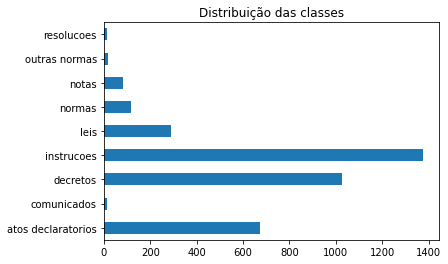

In [10]:
df['Label'].value_counts().sort_index().plot(kind='barh')
plt.title('Distribuição das classes')
plt.show()

In [7]:
TextoInicial = df['Content'][0]


## 3) Pré-processamento

#### 3.1) Aplicação do pré-processamento
Aqui, nós removemos todos os valores faltantes e fazemos todos os textos da coluna "Content" do dataset serem minúsculos, tmabém removemos as pontuações, símbolos e números deles para facilitar a aplicação em um algoritmo de aprendizagem. Utilizando o método "pool.map", podemos dividir essa tarefa entre os núcleos da CPU para uma execução mais rápida.

In [ ]:
df.dropna(inplace=True)

pool = mp.Pool()
df['Content'] = pool.map(cleaner.clearText, df['Content'])

### 3.2) Comparação entre o texto original e o pré-processado

#### Texto original

In [ ]:
TextoInicial

' \n* Publicado no DOE em 01/02/2013\nATO DECLARATÓRIO Nº  01 /2013\nO SECRETÁRIO DA FAZENDA DO ESTADO DO CEARÁ, no uso de suas atribuições \nlegais.\nRESOLVE:\n1. Revogar, a pedido do contribuinte, o Termo de Acordo FDI/PCDM nº 464, de 14 de \nagosto de 2008, celebrado com a empresa TECNO INDÚSTRIA E COMÉRCIO DE \nCOMPUTADORES LTDA, inscrita no CGF sob o  nº 06.358.939-7.\n2. Este Ato Declaratório gera efeito a partir de 1º de fevereiro de 2013\n3. Publique-se. Cumpra-se. Dê-se ciência à interessada.\nSECRETARIO DA FAZENDA DO ESTADO DO CEARÁ, aos 28 de janeiro de 2013\nCarlos Mauro Benevides Filho\n  SECRETÁRIO DA FAZENDA '

#### Texto após pré-processamento

In [ ]:
df['Content'][1]

'publicado doe ato declaratório secretário fazenda estado ceará uso atribuições legais resolve revogar pedido contribuinte termo acordo fdi pcdm outubro celebrado empresa tecno indústria comércio computadores ltda inscrita cgf sob ato declaratório gera efeito partir fevereiro publique-se cumpra-se dê-se ciência interessada secretario fazenda estado ceará janeiro carlos mauro benevides filho secretário fazenda'

### 3.3) Adição da coluna Class com o número das classes
Por fim, para podermos aplicar o dataset no modelo de aprendizagem, precisamos, também, de uma coluna que relaciona o nome da classe com um número. O código abaixo faz exatamente isso.

In [ ]:
dicClassToLabel = {}
dicLabelToClass = {}
nClass = 0

labels = df["Label"].unique()
nlabels = len(labels)

for i in labels:
    if i not in dicClassToLabel:
        dicClassToLabel[i] = nClass
        dicLabelToClass[nClass] = i
        nClass += 1
      
def toLabel(x):
    return dicClassToLabel[x]

In [ ]:
df["Class"] = df["Label"].map(toLabel)
df

,Title,Content,Label,Class
0,"Ato Declaratorio nº 01, de 2013",publicado doe ato declaratório secretário faze...,atos declaratorios,0
1,"Ato Declaratorio nº 02, de 2013",publicado doe ato declaratório secretário faze...,atos declaratorios,0
2,"Ato Declaratório nº 01, de 1998",ato declaratório publicado doe secretário faze...,atos declaratorios,0
3,"Ato Declaratório nº 01, de 1999",ato declaratório publicado doe secretário faze...,atos declaratorios,0
4,"Ato Declaratório nº 01, de 2000",ato declaratório publicado doe secretário faze...,atos declaratorios,0
...,...,...,...,...
3601,"Resolução SEFAZ_SETUR nº 02, de 2019",governo estado ceará secretaria fazenda secret...,resolucoes,8
3602,"Resolução SEFAZ_SETUR nº 03, de 2019",governo estado ceará secretaria fazenda secret...,resolucoes,8
3603,"Resolução SEFAZ_SETUR nº 04, de 2019",governo estado ceará secretaria fazenda secret...,resolucoes,8
3604,"Resolução CONTRAN Nº 398, de 2011",resolução dezembro estabelece orientações proc...,resolucoes,8


### 3.4) Salvando o dataset modificado

In [ ]:
df.to_csv('/content/drive/My Drive/TrabalhoFinal/ArquivosProcessados.csv', index=False)

## 4) Testando alguns modelos de classificação com o dataset
Aqui, nós aplicamos alguns modelos de classificação no dataset e verificamos a eficácia deles através de uma Cross Validation de 5-folds.

### 4.1) Carregando o dataset salvo anteriormente

In [ ]:
# Para quem quer pular o Pré-Processamento e começar daqui!
df = pd.read_csv('/content/drive/My Drive/TrabalhoFinal/ArquivosProcessados.csv')

labels = df["Label"].unique()
nlabels = len(labels)

### 4.2) Separação do dataset entre treino e teste de forma aleatória

In [ ]:
treino, teste = train_test_split(df, train_size=0.75)

### 4.3) Vetorização da coluna "Content" utilizando o "CountVectorizer" e o "TfidfVectorizer" para comparação

In [ ]:
v_1 = CountVectorizer()
X_treino_1 = v_1.fit_transform(treino["Content"])

v_2 = TfidfVectorizer()
X_treino_2 = v_2.fit_transform(treino["Content"])

### 4.4) Testando modelos de classificação


#### 4.4.1) Testando o modelo Complement Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB

cNB = ComplementNB()
scores_1 = cross_val_score(cNB, X_treino_1, treino["Class"], cv=5)
scores_2 = cross_val_score(cNB, X_treino_2, treino["Class"], cv=5)

print("Média da Cross Validation com CountVectorizer:", scores_1.mean() * 100, "%")
print("Média da Cross Validation com TfidfVectorizer:", scores_2.mean() * 100, "%")

Média da Cross Validation com CountVectorizer: 94.67310193742726 %
Média da Cross Validation com TfidfVectorizer: 90.49202437187648 %


In [ ]:
from sklearn.metrics import classification_report
cNB_report = classification_report(teste["Class"], cNB_pred, target_names = labels)
print(cNB_report)

                    precision    recall  f1-score   support

atos declaratorios       0.96      0.99      0.98       168
       comunicados       0.00      0.00      0.00         3
          decretos       0.92      0.97      0.95       262
        instrucoes       0.97      0.97      0.97       343
              leis       0.92      0.96      0.94        71
            normas       1.00      0.64      0.78        22
             notas       1.00      0.56      0.71        27
     outras normas       1.00      0.33      0.50         3
        resolucoes       0.75      1.00      0.86         3

          accuracy                           0.95       902
         macro avg       0.83      0.71      0.74       902
      weighted avg       0.95      0.95      0.94       902



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


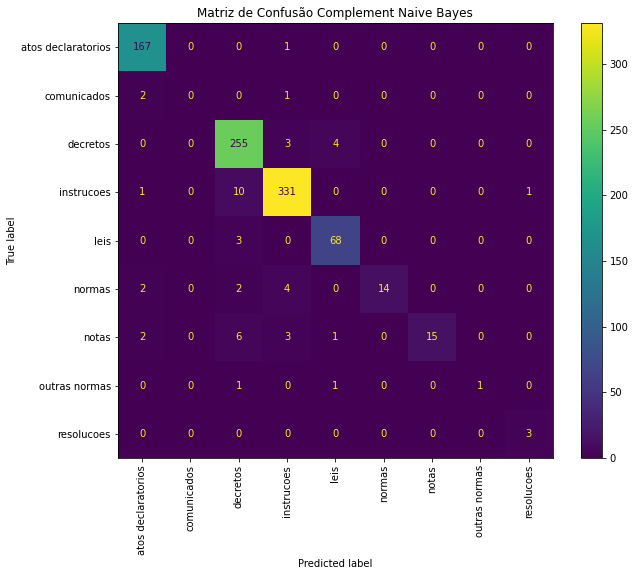

In [ ]:
from sklearn.metrics import plot_confusion_matrix
COLOR = 'white' # caso queira pegar a imagem para os slides
# COLOR = 'black' # caso queira visualizar no Colab
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
xAx = 10 
yAx = 8
fig, ax = plt.subplots(figsize=(xAx, yAx))
plot_confusion_matrix(cNB, X_teste_1, teste["Class"], display_labels = labels, values_format = 'd' ,xticks_rotation = 'vertical', ax = ax)
plt.title("Matriz de Confusão Complement Naive Bayes")
plt.show()

#### 4.4.2) Testando o modelo Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=2, max_iter=10000, penalty='l1', solver='liblinear')
scores_1 = cross_val_score(lr, X_treino_1, treino["Class"], cv=5)
scores_2 = cross_val_score(lr, X_treino_2, treino["Class"], cv=5)

print("Média da Cross Validation com CountVectorizer:", scores_1.mean() * 100, "%")
print("Média da Cross Validation com TfidfVectorizer:", scores_2.mean() * 100, "%")

Média da Cross Validation com CountVectorizer: 99.00102690490861 %
Média da Cross Validation com TfidfVectorizer: 98.37208187855137 %


Como o CountVectorizer obteve melhor resultado, vamos treinar o modelo com ele.

In [ ]:
lr.fit(X_treino_1,treino["Class"])

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_pred = lr.predict(X_teste_1)

In [ ]:
lr_report = classification_report(teste["Class"], lr_pred, target_names = labels)
print(lr_report)

                    precision    recall  f1-score   support

atos declaratorios       0.99      1.00      1.00       168
       comunicados       1.00      0.33      0.50         3
          decretos       1.00      1.00      1.00       262
        instrucoes       0.99      1.00      1.00       343
              leis       0.97      1.00      0.99        71
            normas       1.00      0.95      0.98        22
             notas       1.00      1.00      1.00        27
     outras normas       1.00      0.33      0.50         3
        resolucoes       1.00      1.00      1.00         3

          accuracy                           0.99       902
         macro avg       1.00      0.85      0.88       902
      weighted avg       0.99      0.99      0.99       902



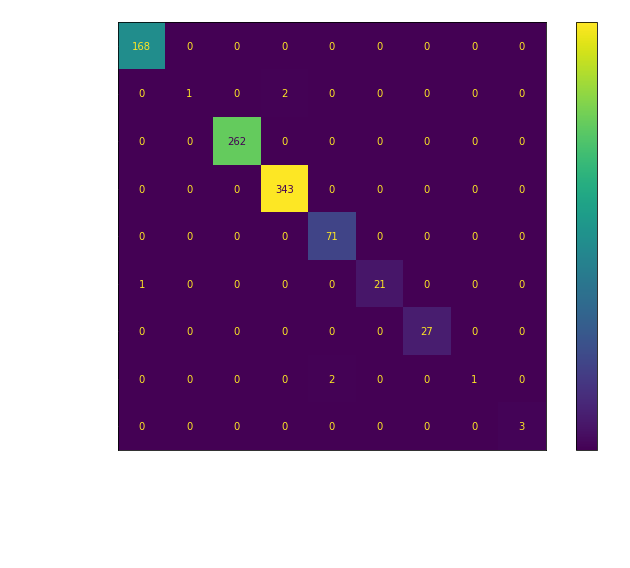

In [ ]:
fig, ax = plt.subplots(figsize=(xAx, yAx))

plot_confusion_matrix(lr, X_teste_1, teste["Class"], display_labels = labels, values_format = 'd' ,xticks_rotation = 'vertical', ax = ax)
plt.title("Matriz de Confusão Regressão Logística")
plt.tight_layout()
plt.savefig("lr.png", transparent=True)
plt.show()

#### 4.4.3) Testando o modelo SVM (sigmoid e linear)


In [ ]:
from sklearn import svm

sv = svm.SVC(C=2, kernel='sigmoid')
scores_1 = cross_val_score(sv, X_treino_1, treino["Class"], cv=5)
scores_2 = cross_val_score(sv, X_treino_2, treino["Class"], cv=5)

print("Média da Cross Validation com CountVectorizer:", scores_1.mean() * 100, "%")
print("Média da Cross Validation com TfidfVectorizer:", scores_2.mean() * 100, "%")

Média da Cross Validation com CountVectorizer: 98.29814472513178 %
Média da Cross Validation com TfidfVectorizer: 97.74347915383036 %


In [ ]:
lsv = svm.LinearSVC(C=2, dual=False, max_iter=20000, penalty='l1')
scores_1 = cross_val_score(lsv, X_treino_1, treino["Class"], cv=5)
scores_2 = cross_val_score(lsv, X_treino_2, treino["Class"], cv=5)

print("Média da Cross Validation com CountVectorizer:", scores_1.mean() * 100, "%")
print("Média da Cross Validation com TfidfVectorizer:", scores_2.mean() * 100, "%")

Média da Cross Validation com CountVectorizer: 99.11200109536523 %
Média da Cross Validation com TfidfVectorizer: 99.1121380160197 %


Como o CountVectorizer obteve melhor resultado, vamos treinar o modelo com ele.

In [ ]:
sv.fit(X_treino_1,treino["Class"])

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
sv_pred = sv.predict(X_teste_1)

In [ ]:
sv_report = classification_report(teste["Class"], sv_pred, target_names = labels)
print(sv_report)

                    precision    recall  f1-score   support

atos declaratorios       0.99      0.99      0.99       168
       comunicados       0.00      0.00      0.00         3
          decretos       1.00      1.00      1.00       262
        instrucoes       0.98      1.00      0.99       343
              leis       0.97      1.00      0.99        71
            normas       1.00      0.86      0.93        22
             notas       1.00      0.93      0.96        27
     outras normas       0.50      0.33      0.40         3
        resolucoes       1.00      1.00      1.00         3

          accuracy                           0.99       902
         macro avg       0.83      0.79      0.81       902
      weighted avg       0.98      0.99      0.99       902



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


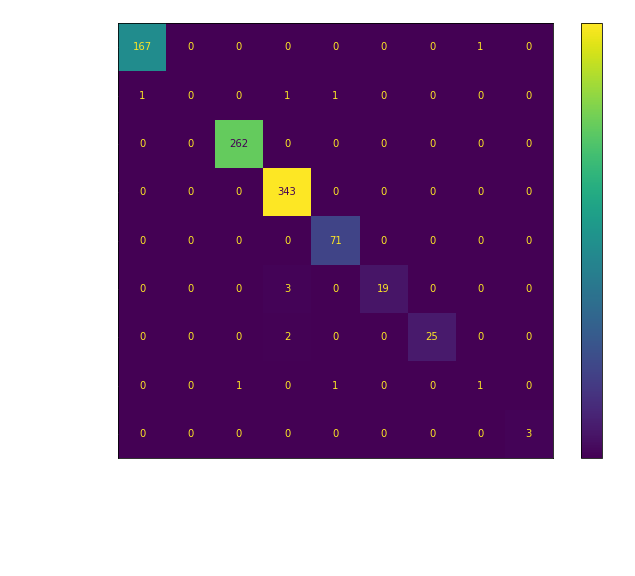

In [ ]:
fig, ax = plt.subplots(figsize=(xAx, yAx))
plot_confusion_matrix(sv, X_teste_1, teste["Class"], display_labels = labels, values_format = 'd' ,xticks_rotation = 'vertical', ax = ax)
plt.title("Matriz de Confusão SVM-sigmoide")
plt.show()

#### 4.4.4) Testando o modelo K-Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
scores_1 = cross_val_score(knc, X_treino_1, treino["Class"], cv=5)
scores_2 = cross_val_score(knc, X_treino_2, treino["Class"], cv=5)

print("Média da Cross Validation com CountVectorizer:", scores_1.mean() * 100, "%")
print("Média da Cross Validation com TfidfVectorizer:", scores_2.mean() * 100, "%")

Média da Cross Validation com CountVectorizer: 90.01074827137673 %
Média da Cross Validation com TfidfVectorizer: 85.53501745738345 %


Como o CountVectorizer obteve melhor resultado, vamos treinar o modelo com ele.

In [ ]:
lsv.fit(X_treino_2,treino["Class"])

LinearSVC(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=20000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
lsv_pred = lsv.predict(X_teste_1)

In [ ]:
lsv_report = classification_report(teste["Class"], lsv_pred, target_names = labels)
print(lsv_report)

                    precision    recall  f1-score   support

atos declaratorios       1.00      1.00      1.00       168
       comunicados       1.00      0.67      0.80         3
          decretos       1.00      1.00      1.00       262
        instrucoes       0.99      1.00      1.00       343
              leis       0.99      1.00      0.99        71
            normas       1.00      1.00      1.00        22
             notas       1.00      0.93      0.96        27
     outras normas       0.50      0.33      0.40         3
        resolucoes       1.00      1.00      1.00         3

          accuracy                           0.99       902
         macro avg       0.94      0.88      0.91       902
      weighted avg       0.99      0.99      0.99       902



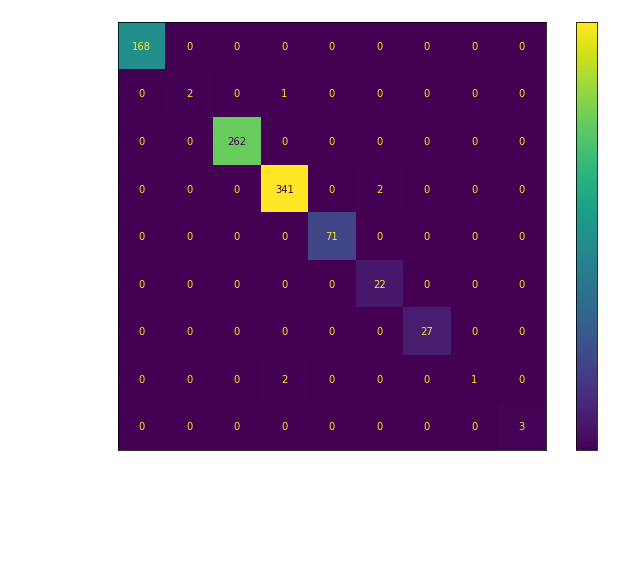

In [ ]:
fig, ax = plt.subplots(figsize=(xAx, yAx))
plot_confusion_matrix(lsv, X_teste_2, teste["Class"], display_labels = labels, values_format = 'd' ,xticks_rotation = 'vertical', ax = ax)
plt.title("Matriz de Confusão SVM-linear")
plt.tight_layout()
plt.savefig("lsv.png", transparent=True)
plt.show()


#### 4.4.5) Testando um modelo de Redes Neurais feito com Keras

Separando os dados em treino, validação e teste

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

treinoRN, val = train_test_split(treino, train_size=0.8)

v_1_rn = CountVectorizer()

X_treino_rn = v_1_rn.fit_transform(treinoRN['Content'])
y_treino_rn = treinoRN['Class']

X_val_rn = v_1_rn.transform(val['Content'])
y_val_rn = val['Class']

X_teste_rn = v_1_rn.transform(teste['Content'])
y_teste_rn = teste['Class']

Criando o modelo de rede neural

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype='int64')

x = layers.Embedding(20000, 256)(inputs)
x = layers.Conv1D(256, 10, activation='relu', strides=10)(x)
x = layers.Conv1D(256, 10, activation='relu', strides=10)(x)
x = layers.Conv1D(256, 10, activation='relu', strides=10)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(nlabels, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         655616    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         655616    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         655616    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)              

Treinando o modelo com os dados de treino e validando com os de validação

In [ ]:
history = model.fit(X_treino_rn.toarray(), y_treino_rn, validation_data=(X_val_rn.toarray(), y_val_rn), epochs=10, verbose=True)

Epoch 1/10
68/68 [==============================] - 18s 259ms/step - loss: 1.6018 - accuracy: 0.3460 - val_loss: 1.5933 - val_accuracy: 0.4122
Epoch 2/10
68/68 [==============================] - 17s 250ms/step - loss: 1.5366 - accuracy: 0.3603 - val_loss: 1.5080 - val_accuracy: 0.4122
Epoch 3/10
68/68 [==============================] - 17s 250ms/step - loss: 1.5675 - accuracy: 0.3636 - val_loss: 1.5057 - val_accuracy: 0.2643
Epoch 4/10
68/68 [==============================] - 17s 250ms/step - loss: 0.5225 - accuracy: 0.8224 - val_loss: 0.1585 - val_accuracy: 0.9612
Epoch 5/10
68/68 [==============================] - 17s 250ms/step - loss: 0.1039 - accuracy: 0.9699 - val_loss: 0.0976 - val_accuracy: 0.9741
Epoch 6/10
68/68 [==============================] - 17s 250ms/step - loss: 0.0468 - accuracy: 0.9857 - val_loss: 0.0487 - val_accuracy: 0.9852
Epoch 7/10
68/68 [==============================] - 17s 250ms/step - loss: 0.0169 - accuracy: 0.9940 - val_loss: 0.0809 - val_accuracy: 0.9686

Testando o modelo com os dados de teste

In [ ]:
score = model.evaluate(X_teste_rn.toarray(), y_teste_rn)

print("Precisão do modelo com CountVectorizer:", score[1] * 100, "%")

29/29 [==============================] - 3s 91ms/step - loss: 0.0764 - accuracy: 0.9812
Precisão do modelo com CountVectorizer: 98.11530113220215 %


## 5) Treinando e salvando o melhor modelo com os dados do dataset

 Após treinar e avaliar os modelos na seção 4), vimos que os que obtiveram melhor desemepnho foram os modelos de Regressão Logística e o de SVM-Linear. Tendo isto em vista, escolhemos a Regressão Logística para ser nosso modelo final, e agora iremos criar uma pipeline para ele, para então utilizá-lo em uma aplicação Flask

In [ ]:
df = pd.read_csv('/content/drive/My Drive/TrabalhoFinal/ArquivosProcessados.csv')

conteudo = df['Content']
classes = df['Class']

labels = df["Label"].unique()
nlabels = len(labels)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimadores = [('vetorizador', CountVectorizer()), ('clf', LogisticRegression(C=2, max_iter=10000, penalty='l1', solver='liblinear'))]
pipe = Pipeline(estimadores)
pipe.fit(conteudo, classes)

Pipeline(memory=None,
         steps=[('vetorizador',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                   

In [ ]:
dicClassToLabel = {}
dicLabelToClass = {}
nClass = 0

labels = df["Label"].unique()
nlabels = len(labels)

for i in labels:
    if i not in dicClassToLabel:
        dicClassToLabel[i] = nClass
        dicLabelToClass[nClass] = i
        nClass += 1

In [ ]:
from joblib import dump
dump([dicLabelToClass, pipe], '/content/drive/My Drive/TrabalhoFinal/modelo.joblib')

['/content/drive/My Drive/TrabalhoFinal/modelo.joblib']

In [ ]:
dicLabelToClass

{0: 'atos declaratorios',
 1: 'comunicados',
 2: 'decretos',
 3: 'instrucoes',
 4: 'leis',
 5: 'normas',
 6: 'notas',
 7: 'outras normas',
 8: 'resolucoes'}

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'